In [113]:
import pandas as pd
import sklearn.metrics as skm
import numpy as np

import seaborn as sns
sns.set_theme()

In [114]:
TAGGED_SAMPLED_TOKENS_CSV_NAME = 'english_samples_v4_annotations.csv'#'sampled_tagged.csv' # 'english_samples_v4_annotations.csv'
TAGGER_TO_CHILDES_POS_MAPPING_CSV_NAME = "spacy_childes_pos_mapping_full - spacy_childes_pos_mapping_full.csv"
CHILDES_POS_REMAPPING_CSV_NAME = "childes_pos_remapping_full - childes_simplified_pos_full.csv"
MODEL_NAME = 'spacy'
CONVERTED_SAMPLED_TOKENS_CSV_NAME = 'sampled_remapped.csv'

In [115]:
samples = pd.read_csv(TAGGED_SAMPLED_TOKENS_CSV_NAME, keep_default_na=False, index_col=0)
samples

,token_id,gloss,utterance_id,utterance_gloss,part_of_speech,log_frequency_bin,speaker_role,spacy_part_of_speech,spacy_morphology,childes_remapped_part_of_speech,spacy_pos_converted,agree,correct_pos,ill-formed,comment
0,61545509,ought,16869004,the shortcut led right to where Harold thought...,mod,1,Mother,AUX,VerbType=Mod,mod,mod,True,mod,,
1,62585566,onto,17115248,I'm not allowing you to reach things onto the ...,prep,2,Mother,ADP,,prep,prep,True,prep,,
2,62696473,dare,17144700,I dare not go,mod,1,Mother,AUX,Tense=Pres|VerbForm=Fin,mod,mod,True,mod,,
3,62150711,behind,17024078,yyy knee behind the letters,prep,2,Target_Child,ADP,,prep,prep,True,prep,,
4,62040337,greenish,16983158,is that kind of a greenish blue,adj,0,Mother,ADJ,Degree=Pos,adj,adj,True,adj,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1198,61329354,thirteen,16820893,before thirteen,det:num,1,Media,NUM,NumType=Card,num,num,True,num,,
1199,61330648,eighteen,16827005,eighteen,det:num,1,Mother,NUM,NumType=Card,num,num,True,num,,
1200,61329154,thirteen,16819772,thirteen good job,det:num,1,Media,NUM,NumType=Card,num,num,True,num,,
1201,62751605,seven,17160155,six little fingers icy and shaking seven littl...,det:num,2,Mother,NUM,NumType=Card,num,num,True,num,,


In [116]:
tagger_childes_mapping = pd.read_csv(TAGGER_TO_CHILDES_POS_MAPPING_CSV_NAME, keep_default_na=False)
childes_remapping = pd.read_csv(CHILDES_POS_REMAPPING_CSV_NAME, keep_default_na=False)
# tagger_childes_mapping.rename(columns={'spacy_part_of_speech':'tagger_part_of_speech', 'spacy_morphology':'tagger_morphology', 'spacy_pos_converted':'tagger_pos_converted'}, inplace=True)

def tagger_to_childes_pos(tagger_pos, tagger_morph):
    '''
    given a tagger's part-of-speech and morphology, return a converted part-of-speech
    '''
    matches = tagger_childes_mapping[tagger_childes_mapping[MODEL_NAME + '_part_of_speech'] == tagger_pos]
    matches = matches[matches[MODEL_NAME + '_morphology'] == tagger_morph]
    if len(matches) < 1:
        print("no match for", tagger_pos, tagger_morph)
        return ""
    # return matches.iloc[0]['childes_remapped_part_of_speech']
    return matches.iloc[0][MODEL_NAME + '_pos_converted']

def childes_remapped_pos(childes_pos, tagger_pos):
    '''
    given a childes part-of-speech, return its remapped form
    necessary because some tagger categories map to multiple more specific childes categories, which are all correct
    '''
    # first check if it's an interjection -- there is no good childes tag, so consider them all correct
    if tagger_pos == "INTJ" or tagger_pos == 'intj' or tagger_pos == 'UH':
        new_pos = "intj"
        return new_pos
    
    # if not, then use the mapping in childes_remapping
    # matches = childes_remapping[childes_remapping['childes_original_pos'] == childes_pos]
    matches = childes_remapping[childes_remapping['childes_simplified_pos'] == childes_pos]
    new_pos = matches.iloc[0]['childes_remapped_pos']
    return new_pos

In [117]:
new_samples = samples.copy()
new_samples["childes_remapped_part_of_speech"] = new_samples.apply(lambda row: childes_remapped_pos(row["part_of_speech"], row[MODEL_NAME + "_part_of_speech"]), axis=1)
new_samples[MODEL_NAME + "_pos_converted"] = new_samples.apply(lambda row: tagger_to_childes_pos(row[MODEL_NAME + "_part_of_speech"], row[MODEL_NAME + "_morphology"]), axis=1)
new_samples['agree'] = new_samples['childes_remapped_part_of_speech'] == new_samples[MODEL_NAME + "_pos_converted"]
new_samples

,token_id,gloss,utterance_id,utterance_gloss,part_of_speech,log_frequency_bin,speaker_role,spacy_part_of_speech,spacy_morphology,childes_remapped_part_of_speech,spacy_pos_converted,agree,correct_pos,ill-formed,comment
0,61545509,ought,16869004,the shortcut led right to where Harold thought...,mod,1,Mother,AUX,VerbType=Mod,mod,mod,True,mod,,
1,62585566,onto,17115248,I'm not allowing you to reach things onto the ...,prep,2,Mother,ADP,,prep,prep,True,prep,,
2,62696473,dare,17144700,I dare not go,mod,1,Mother,AUX,Tense=Pres|VerbForm=Fin,mod,mod,True,mod,,
3,62150711,behind,17024078,yyy knee behind the letters,prep,2,Target_Child,ADP,,prep,prep,True,prep,,
4,62040337,greenish,16983158,is that kind of a greenish blue,adj,0,Mother,ADJ,Degree=Pos,adj,adj,True,adj,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1198,61329354,thirteen,16820893,before thirteen,det:num,1,Media,NUM,NumType=Card,num,num,True,num,,
1199,61330648,eighteen,16827005,eighteen,det:num,1,Mother,NUM,NumType=Card,num,num,True,num,,
1200,61329154,thirteen,16819772,thirteen good job,det:num,1,Media,NUM,NumType=Card,num,num,True,num,,
1201,62751605,seven,17160155,six little fingers icy and shaking seven littl...,det:num,2,Mother,NUM,NumType=Card,num,num,True,num,,


In [118]:
# in the absence of full annotations, these functions assume that childes/spacy are correct if they agree
# ideally, do not use this assumption

# to use, call new_samples['temporary_gold'] = new_samples.apply(lambda x: fill_gold(x), axis=1)

def fill_gold(x):
    if x['correct_pos'] != '':
        return x['correct_pos']
    if x['childes_remapped_part_of_speech'] == x[MODEL_NAME + '_pos_converted']:
        return x['childes_remapped_part_of_speech']
    return '' # we don't know the gold label

def childes_match_gold(x):
    childes_label, tagger_label, gold = x['childes_remapped_part_of_speech'], x[MODEL_NAME + '_pos_converted'], x['temporary_gold']
    if gold == "":
        return childes_label == tagger_label
    return childes_label == gold

def tagger_match_gold(x):
    childes_label, tagger_label, gold = x['childes_remapped_part_of_speech'], x[MODEL_NAME + '_pos_converted'], x['temporary_gold']
    if gold == "":
        return childes_label == tagger_label
    return tagger_label == gold

def score(df, use_childes=True):
    if use_childes:
        col_name = "childes_remapped_part_of_speech"
    else:
        col_name = MODEL_NAME + '_pos_converted'
        
    labels = df[col_name].drop_duplicates()
    p = skm.precision_score(new_samples["temporary_gold"], new_samples[col_name], labels=labels, average='micro')
    r = skm.recall_score(new_samples["temporary_gold"], new_samples[col_name], labels=labels, average='micro')
    f1 = skm.f1_score(new_samples["temporary_gold"], new_samples[col_name], labels=labels, average='micro')
    return {'precision': p, 'recall': r, 'f1': f1}

def confusion_matrix(df, use_childes=True):
    if use_childes:
        col_name = "childes_remapped_part_of_speech"
    else:
        col_name = MODEL_NAME + '_pos_converted'
        
    labels = df[col_name].drop_duplicates()
    confusion = skm.confusion_matrix(new_samples["temporary_gold"], new_samples[col_name], labels=labels)
    return {'labels': labels, 'matrix': confusion}



In [213]:
# df is the version of samples that ignores tokens without a gold annotation

def remove_bad_labels(x):
    if x['correct_pos'].strip() == MODEL_NAME:
        return x['{}_pos_converted'.format(MODEL_NAME)]
    elif x['correct_pos'].strip() == 'childes':
        return x['childes_remapped_part_of_speech']
    return x['correct_pos']

df = new_samples[~(new_samples['correct_pos'] == '')]
df = df[~(df['correct_pos'] == 'on')]
df['correct_pos'] = df['correct_pos'].str.rstrip()
df['correct_pos'] = df.apply(lambda x: remove_bad_labels(x), axis=1)
df

,token_id,gloss,utterance_id,utterance_gloss,part_of_speech,log_frequency_bin,speaker_role,spacy_part_of_speech,spacy_morphology,childes_remapped_part_of_speech,spacy_pos_converted,agree,correct_pos,ill-formed,comment,temporary_gold
0,61545509,ought,16869004,the shortcut led right to where Harold thought...,mod,1,Mother,AUX,VerbType=Mod,mod,mod,True,mod,,,mod
1,62585566,onto,17115248,I'm not allowing you to reach things onto the ...,prep,2,Mother,ADP,,prep,prep,True,prep,,,prep
2,62696473,dare,17144700,I dare not go,mod,1,Mother,AUX,Tense=Pres|VerbForm=Fin,mod,mod,True,mod,,,mod
3,62150711,behind,17024078,yyy knee behind the letters,prep,2,Target_Child,ADP,,prep,prep,True,prep,,,prep
4,62040337,greenish,16983158,is that kind of a greenish blue,adj,0,Mother,ADJ,Degree=Pos,adj,adj,True,adj,,,adj
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1198,61329354,thirteen,16820893,before thirteen,det:num,1,Media,NUM,NumType=Card,num,num,True,num,,,num
1199,61330648,eighteen,16827005,eighteen,det:num,1,Mother,NUM,NumType=Card,num,num,True,num,,,num
1200,61329154,thirteen,16819772,thirteen good job,det:num,1,Media,NUM,NumType=Card,num,num,True,num,,,num
1201,62751605,seven,17160155,six little fingers icy and shaking seven littl...,det:num,2,Mother,NUM,NumType=Card,num,num,True,num,,,num


In [207]:
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm

def print_confusion_matrix(df, col_evaluate, plot_title=None, file_name=None, normalized=True):
    """
    df: dataframe with columns `correct_pos`, col_evaluate
    col_evaluate: name of column to evaluate against `correct_pos`, e.g. `childes_remapped_part_of_speech`, `spacy_pos_converted`
    plot_title: title of plot
    file_name: file name to save plot under
    normalized: use proportions if True, use raw values if False
    
    Adapted from https://seaborn.pydata.org/examples/structured_heatmap.html
    """
    
    gold_labels = list(df['correct_pos'].drop_duplicates(keep='first'))
    childes_labels = list(df[col_evaluate].drop_duplicates(keep='first'))
    labels = list(set(gold_labels) | set(childes_labels))
    
    # Create a categorical palette to identify the networks
    # network_pal = sns.husl_palette(8, s=.45)
    network_pal = sns.husl_palette(len(labels), s=.45)
    # network_lut = dict(zip(map(str, used_networks), network_pal))
    network_lut = dict(zip(map(str, labels), network_pal))

    # Convert the palette to vectors that will be drawn on the side of the matrix
    # networks = df.columns.get_level_values("network")
    networks = labels
    network_colors = pd.Series(networks, index=df.columns).map(network_lut).to_numpy()

    vals = skm.confusion_matrix(df["correct_pos"], df[col_evaluate], labels=labels)
    #print(vals)
    if normalized:
        vals_norm = np.nan_to_num(vals/vals.astype(np.float).sum(axis=1)[:, np.newaxis], nan=0)
        vals_labeled = pd.DataFrame(vals_norm, columns = labels, index = labels)
    else:
        vals_labeled = pd.DataFrame(vals, columns=labels, index=labels)
    # Draw the full plot
    '''g = sns.clustermap(vals_labeled, center=0, cmap="vlag",
                       row_colors=network_colors, col_colors=network_colors,
                       dendrogram_ratio=(.1, .2),
                       cbar_pos=(.02, .32, .03, .2),
                       linewidths=.75, figsize=(12, 13), annot=True)''' # for linear color scale
    
    #ticks = [0, 0.05, 0.1, 0.2, 0.5, 0.8, 1]
    ticks = [i/10 for i in range(0,11)]
    g = sns.clustermap(vals_labeled, center=0, cmap="vlag",
                       row_colors=network_colors, col_colors=network_colors,
                       dendrogram_ratio=(.1, .2),
                       cbar_pos=(.02, .32, .03, .2),
                       linewidths=.75, figsize=(12, 13), annot=True, 
                       cbar_kws={'ticks': ticks},
                       xticklabels=True, yticklabels=True,
                       norm=PowerNorm(0.5))
    g.ax_heatmap.collections[0].colorbar.set_ticklabels(ticks)
    
    # Remove dendrograms (trees)
    g.ax_row_dendrogram.remove()
    g.ax_col_dendrogram.remove()
    
    # Add plot title
    # Position of title might be bad with other dfs, adjust position by changing value of `y`
    plt.suptitle(plot_title, fontsize = 16, y=0.85)
    
    # Label axes
    ax = g.ax_heatmap
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("Actual label")

    if file_name:
        g.savefig(file_name)
    

/home/szhi/childes-db/childes_py3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/home/szhi/childes-db/childes_py3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


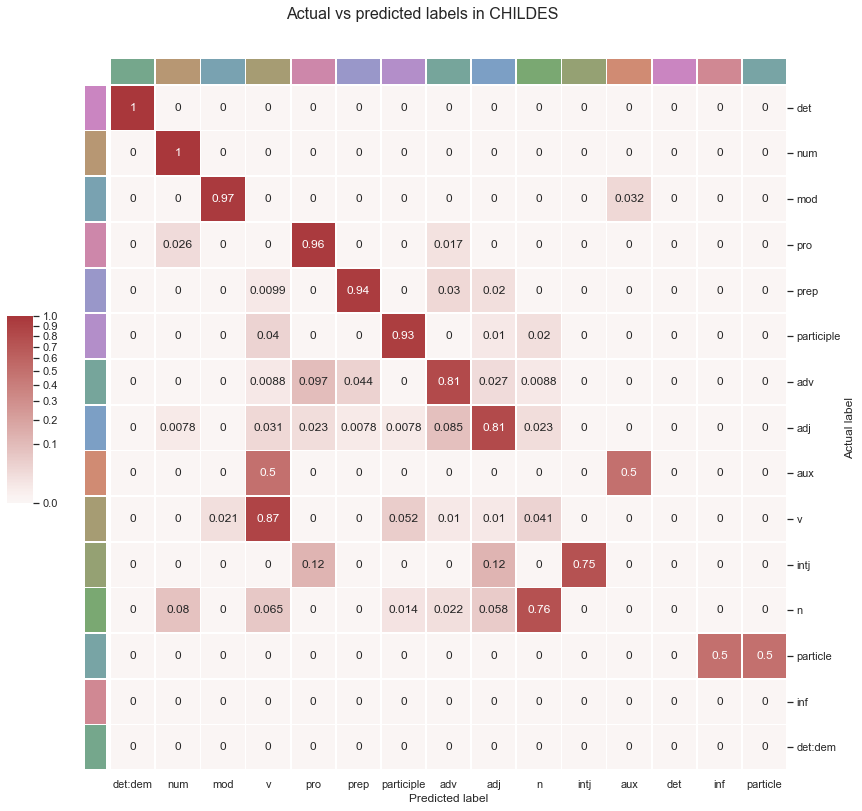

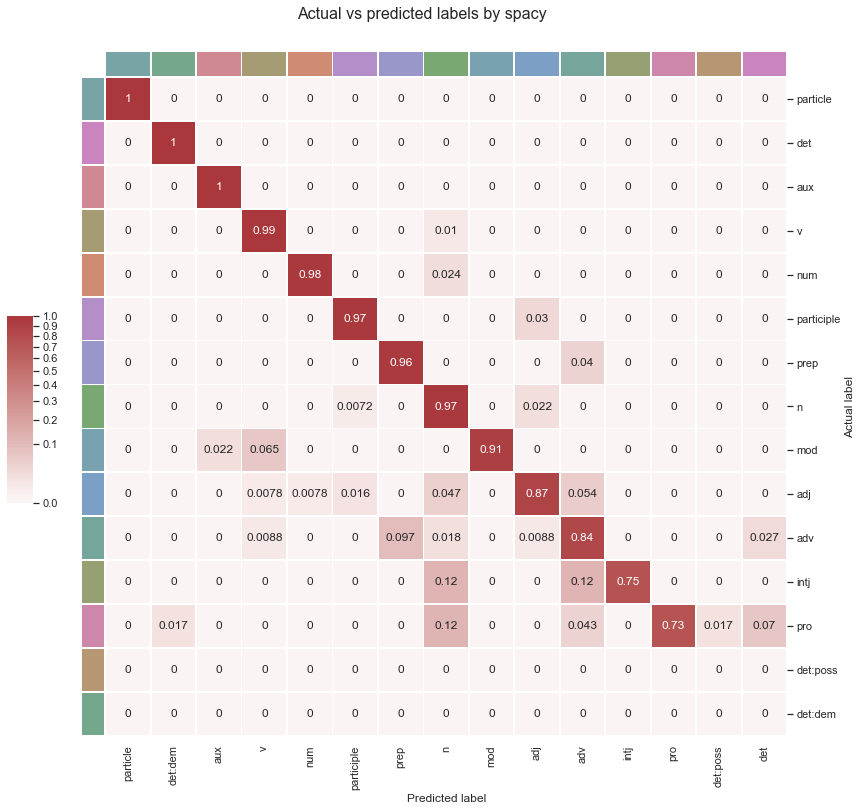

In [212]:
print_confusion_matrix(df, 'childes_remapped_part_of_speech', 
                       plot_title='Actual vs predicted labels in CHILDES', 
                       file_name="english_childes_confusion_matrix.jpg")

print_confusion_matrix(df, '{}_pos_converted'.format(MODEL_NAME), 
                       plot_title='Actual vs predicted labels by {}'.format(MODEL_NAME), 
                       file_name="english_{}_confusion_matrix.jpg".format(MODEL_NAME))



In [211]:
def correct_score(df, use_childes=True):
    if use_childes:
        col_name = "childes_remapped_part_of_speech"
    else:
        col_name = MODEL_NAME + '_pos_converted'
        
    labels = df[col_name].drop_duplicates()
    p = skm.precision_score(new_samples["correct_pos"], new_samples[col_name], labels=labels, average='micro')
    r = skm.recall_score(new_samples["correct_pos"], new_samples[col_name], labels=labels, average='micro')
    f1 = skm.f1_score(new_samples["correct_pos"], new_samples[col_name], labels=labels, average='micro')
    return {'precision': p, 'recall': r, 'f1': f1}

def print_scores_by_group(by):
    groupby = new_samples.groupby(by=by)
    for name, group in groupby:
        print(name)
        # print(group)
        print(correct_score(group))

print("childes:", correct_score(df))
print(MODEL_NAME+":", correct_score(df, use_childes=False))

#print_scores_by_group('correct_pos')

# print_scores_by_group('speaker_role')

# print_scores_by_group('log_frequency_bin')

# judge by utterance length
'''
utt_len_samples = df.copy()
utt_len_samples['utterance_length'] = utt_len_samples.apply(lambda x: len(x['utterance_gloss']), axis=1)
gb = utt_len_samples.groupby(by='utterance_length')
for name, group in gb:
    print(name)
    print(correct_score(group))
'''

childes: {'precision': 0.69803250641574, 'recall': 0.8774193548387097, 'f1': 0.7775131014768938}
spacy: {'precision': 0.7150127226463104, 'recall': 0.9054779806659506, 'f1': 0.7990521327014218}


"\nutt_len_samples = df.copy()\nutt_len_samples['utterance_length'] = utt_len_samples.apply(lambda x: len(x['utterance_gloss']), axis=1)\ngb = utt_len_samples.groupby(by='utterance_length')\nfor name, group in gb:\n    print(name)\n    print(correct_score(group))\n"

In [210]:
# example code for using `temporary_gold` field (when assuming childes/tagger agreeing --> correct)
"""
new_samples['temporary_gold'] = new_samples.apply(lambda x: fill_gold(x), axis=1)

def print_scores_by_group(by):
    groupby = new_samples.groupby(by=by)
    for name, group in groupby:
        print(name)
        # print(group)
        print(score(group))

print("overall:")
print(score(new_samples))
print(score(new_samples, use_childes=False))

#print_scores_by_group('temporary_gold')
# TODO: need to delete space after mod in temporary_gold labels
# aux precision is low
# surprisingly noun scores are not that high

# print_scores_by_group('speaker_role')
# no particular speaker has especially high or low scores (except Visitor but only bc so few samples)

# print_scores_by_group('log_frequency_bin')
# no frequency bin has especially high or low scores

# print_scores_by_group(['temporary_gold', 'log_frequency_bin'])
# still no patterns

# judge by utterance length
'''
utt_len_samples = new_samples.copy()
utt_len_samples['utterance_length'] = utt_len_samples.apply(lambda x: len(x['utterance_gloss']), axis=1)
gb = utt_len_samples.groupby(by='utterance_length')
for name, group in gb:
    print(name)
    print(score(group))
'''
# slight improvement towards longer utterances
"""


overall:
{'precision': 0.8146300914380715, 'recall': 0.8949771689497716, 'f1': 0.8529155787641427}
{'precision': 0.8370739817123857, 'recall': 0.919634703196347, 'f1': 0.876414273281114}


"\nutt_len_samples = new_samples.copy()\nutt_len_samples['utterance_length'] = utt_len_samples.apply(lambda x: len(x['utterance_gloss']), axis=1)\ngb = utt_len_samples.groupby(by='utterance_length')\nfor name, group in gb:\n    print(name)\n    print(score(group))\n"

In [95]:
new_samples.to_csv(CONVERTED_SAMPLED_TOKENS_CSV_NAME)